In [1]:
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def load_dummy(ratio=0.8):
    X = np.linspace(-40, 40, num=2000).reshape(-1, 1)
    Y = 0.02*X**3 + 2*X**2 + 30*X + 300*np.random.randn(*X.shape)

    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    features, target = X, Y
    target.shape = -1, 1
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

In [3]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

In [4]:
(X_train, Y_train), (X_valid, Y_valid) = load_boston()
# (X_train, Y_train), (X_valid, Y_valid) = load_dummy()

In [5]:
class Linear():
    def __init__(self, in_features, out_features):
        self.W = 1e-2 * np .random.randn(out_features, in_features)
        self.b = 1e-2 * np.random.randn(out_features)
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        return X @ self.W.T + self.b

In [6]:
class Sigmoid():
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        return 1/(1+np.exp(-X))

In [7]:
class MLP:
    def __init__(self, in_features, mid_features, out_features):
        self.f1 = Linear(in_features, mid_features)
        self.phi = Sigmoid()
        self.f2 = Linear(mid_features, out_features)
        
    def __call__(self, X):
        return self.f2(self.phi(self.f1(X)))
        
    def forward(self, X):
        Z1 = self.f1(X)
        Z2 = self.phi(Z1)
        Z3 = self.f2(Z2)
        return [X, Z1, Z2, Z3]
    
    def grad(self, Y, Z):
        Z0, Z1, Z2, Z3 = Z[0], Z[1], Z[2], Z[3]

        dLdZ3 = Z3 - Y

        dLdW2 = dLdZ3.T @ Z2
        dLdb2 = np.sum(dLdZ3, axis=0)
        dLdZ2 = dLdZ3 * model.f2.W

        expZ1 = np.exp(Z1)
        dLdZ1 = dLdZ2 * (expZ1/(np.exp(2*Z1)+2*expZ1+1))

        dLdW1 = dLdZ1.T @ Z0
        dLdb1 = np.sum(dLdZ1, axis=0)

        return dLdW1, dLdb1, dLdW2, dLdb2

In [8]:
def loss(Y_real, Y_pred):
    return 0.5 * np.sum((Y_real - Y_pred)**2)

In [9]:
class GradientDescent:
    def __init__(self, step=1e-3):
        self.step = step
        
    def update(self, model:MLP, dLdW1, dLdb1, dLdW2, dLdb2):
        """利用梯度dW来更新f的权重"""
        model.f2.W -= self.step * dLdW2
        model.f2.b -= self.step * dLdb2
        
        model.f1.W -= self.step * dLdW1
        model.f1.b -= self.step * dLdb1

In [10]:
%%time
num_features = X_train.shape[-1]
model = MLP(num_features, 30, 1)
opt = GradientDescent(1e-5)

valid_losses = []
train_losses = []
for i in range(1000):
    X, Y = X_train, Y_train
    
    Z = model.forward(X)
    grads = model.grad(Y, Z)
    opt.update(model, *grads)
    
    Y_out = Z[-1]
    cur_valid_loss = loss(Y_valid, model(X_valid))
    cur_train_loss = loss(Y, Y_out)
    valid_losses.append(cur_valid_loss) 
    train_losses.append(cur_train_loss)
    
    if i%100 == 0:
        print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")

Iter 0: loss 66.5749, valid loss 16.1994
Iter 100: loss 8.1549, valid loss 2.4194
Iter 200: loss 8.0909, valid loss 2.3984
Iter 300: loss 8.0753, valid loss 2.3944
Iter 400: loss 8.0599, valid loss 2.3906
Iter 500: loss 8.0444, valid loss 2.3868
Iter 600: loss 8.0289, valid loss 2.3830
Iter 700: loss 8.0135, valid loss 2.3792
Iter 800: loss 7.9980, valid loss 2.3754
Iter 900: loss 7.9824, valid loss 2.3716
CPU times: user 1min, sys: 1min 27s, total: 2min 27s
Wall time: 3.18 s


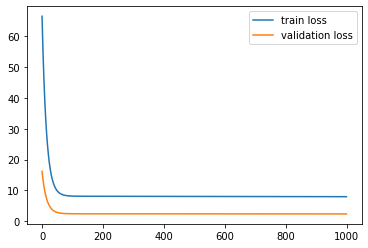

In [11]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])